# Neural Network Models
Using the labelled Lichess data, this notebook will attempt to find a regression neural network which can fit that labelled data.

## Pre-requisites

### If running on Google Collab
If not running on Google collab do not run these next two cells!

In [1]:
# Install the only dependency not available from collab directly
!pip install chess

# Get imported files from repo
!git clone -b lichess-neural-networks https://github.com/owenjaques/chessbot.git
!mv chessbot chessbot-repo
!mv chessbot-repo/neural_networks/chessbot .
!rm chessbot-repo -r

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.1/149.1 KB 4.6 MB/s eta 0:00:00
Cloning into 'chessbot'...
remote: Enumerating objects: 581, done.
remote: Counting objects: 100% (276/276), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 581 (delta 89), reused 182 (delta 55), pack-reused 305
Receiving objects: 100% (581/581), 63.19 MiB | 8.88 MiB/s, done.
Resolving deltas: 100% (281/281), done.


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
working_directory = '/content/gdrive/MyDrive/chessbot_weights/'
data_directory = working_directory

Mounted at /content/gdrive


### If not running on Google Collab
Set the weights directory variable to wherever you would like data saved.

In [ ]:
!mkdir -p bin
working_directory = './bin'
data_directory = '../pre_processing/data'

## Load the Data

In [3]:
import chess
import chess.pgn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import math
import threading
from chessbot import modelinput

### Data generator For Keras

In [11]:
# There is a wierd bug here where more than one worker will cause the input data to get slightly
# messed up, however, using 1 worker seems to be infinitely faster than running this in a loop,
# which is super odd, but I'm not complaining.
def worker(input, output, input_type, start_index, num):
    input_generator = modelinput.ModelInput(input_type)
    
    if input_type == 'all':
        for i in range(num):
            output[0][start_index + i], output[1][start_index + i], output[2][start_index + i] = input_generator.get_input_from_fen(input[start_index + i])
    else:
        for i in range(num):
            output[start_index + i] = input_generator.get_input_from_fen(input[start_index + i])

    print(f'\rThread {start_index // num} completed processing {num} samples.', end='')

class DataGenerator(keras.utils.Sequence):
    def __init__(self, data_file, input_type, batch_size=32, pre_process=True, save_file=None, workers=1):
        self.batch_size = batch_size
        data = np.load(data_file, allow_pickle=True)
        self.y = data['y']
        self.n = len(self.y)
        self.input_type = input_type

        if pre_process:
            input_size = modelinput.ModelInput(input_type).input_length()
            
            if input_type == 'all':
                self.X = []
                self.X.append(np.full((self.n, int(input_size[0])), -1.0))
                self.X.append(np.full((self.n, int(input_size[1])), -1.0))
                self.X.append(np.full((self.n, int(input_size[2])), -1.0))
            else:
                self.X = np.full((self.n, input_size), -1.0)

            step = self.n // workers

            threads = []
            for i in range(0, self.n, step):
                threads.append(threading.Thread(target=worker, args=(data['X'], self.X, input_type, i, step)))
                threads[-1].start()

            for i in range(workers):
                threads[i].join()
            
            if save_file != None:
                np.savez_compressed(save_file, X=self.X, y=self.y)
        else:
            self.X = data['X']

    def __len__(self):
        return math.ceil(self.n / self.batch_size)

    def __getitem__(self, idx):
        # Returns one batch of data
        low = idx * self.batch_size
        high = np.minimum(low + self.batch_size, self.n)
        
        if self.input_type == 'all':
            return [self.X[0][low:high], self.X[1][low:high], self.X[2][low:high]], self.y[low:high]
        
        return self.X[low:high], self.y[low:high]

## Model with one input

### Pre-process the data

In [15]:
training_data = DataGenerator(data_directory + '/training_set.npz', 'positions')
validation_data = DataGenerator(data_directory + '/validation_set.npz', 'positions')

Thread 0 completed processing 12500 samples.

#### Sanity check
Here we check that the training data was transformed correctly. X and y should both be in the range [0, 1].

Training data: n=100000 len(X)=100000
Validation data: n=12500 len(X)=12500


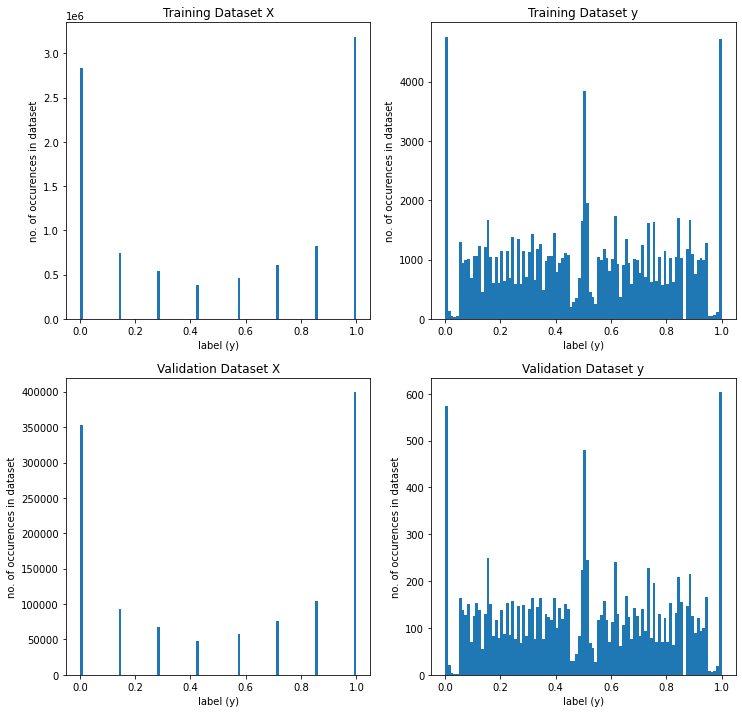

In [16]:
print(f'Training data: n={training_data.n} len(X)={len(training_data.X)}')
print(f'Validation data: n={validation_data.n} len(X)={len(validation_data.X)}')

def sanity_check_single_input(training_data, validation_data):
    _, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

    ax[0, 0].hist(training_data.X.flatten(), bins=100)
    ax[0, 0].set_title(f'Training Dataset X')
    ax[0, 0].set_xlabel('label (y)')
    ax[0, 0].set_ylabel('no. of occurences in dataset')

    ax[0, 1].hist(training_data.y, bins=100)
    ax[0, 1].set_title(f'Training Dataset y')
    ax[0, 1].set_xlabel('label (y)')
    ax[0, 1].set_ylabel('no. of occurences in dataset')

    ax[1, 0].hist(validation_data.X.flatten(), bins=100)
    ax[1, 0].set_title(f'Validation Dataset X')
    ax[1, 0].set_xlabel('label (y)')
    ax[1, 0].set_ylabel('no. of occurences in dataset')

    ax[1, 1].hist(validation_data.y, bins=100)
    ax[1, 1].set_title(f'Validation Dataset y')
    ax[1, 1].set_xlabel('label (y)')
    ax[1, 1].set_ylabel('no. of occurences in dataset')

    plt.show()

sanity_check_single_input(training_data, validation_data)

#### Reduce the number of samples that are ~50% to further balance the dataset

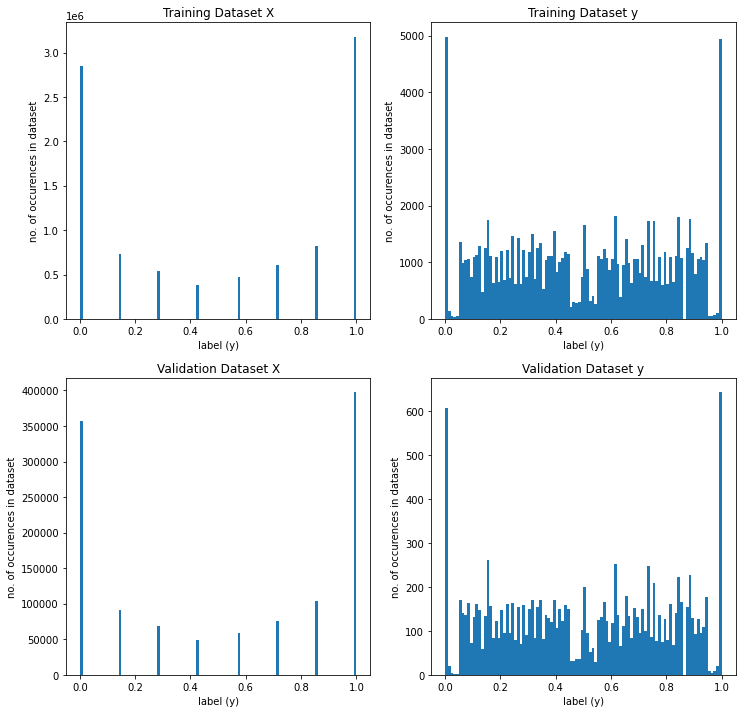

In [17]:
for i in range(training_data.n):
    if 0.475 < training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * training_data.n))
            training_data.y[i] = training_data.y[index]
            training_data.X[i] = training_data.X[index]

for i in range(validation_data.n):
    if 0.475 < validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * validation_data.n))
            validation_data.y[i] = validation_data.y[index]
            validation_data.X[i] = validation_data.X[index]

sanity_check_single_input(training_data, validation_data)

### The actual model we will be using

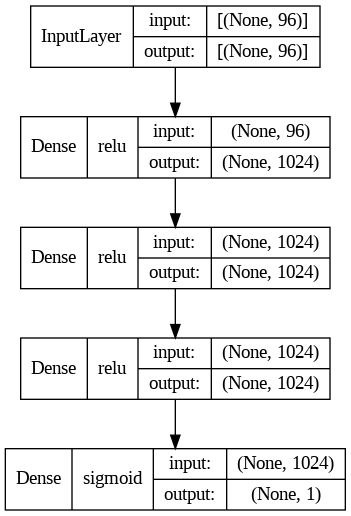

In [21]:
model = keras.Sequential([
	keras.layers.Input(modelinput.ModelInput('positions').input_length()),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1024, activation='relu'),
	keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, to_file='single_input_model.png', show_layer_names=False)

## Model with three inputs
This will test a model with three different inputs, whose network is based on the network from the Giraffe Chess engine (accessible https://arxiv.org/abs/1509.01549).

### Pre-process the Data

In [23]:
training_data = DataGenerator(data_directory + '/training_set.npz', 'all')
validation_data = DataGenerator(data_directory + '/validation_set.npz', 'all')

Thread 0 completed processing 12500 samples.

#### Sanity Check
Like the above model we will check that the dataset has been correctly processed and is in the range [0, 1].

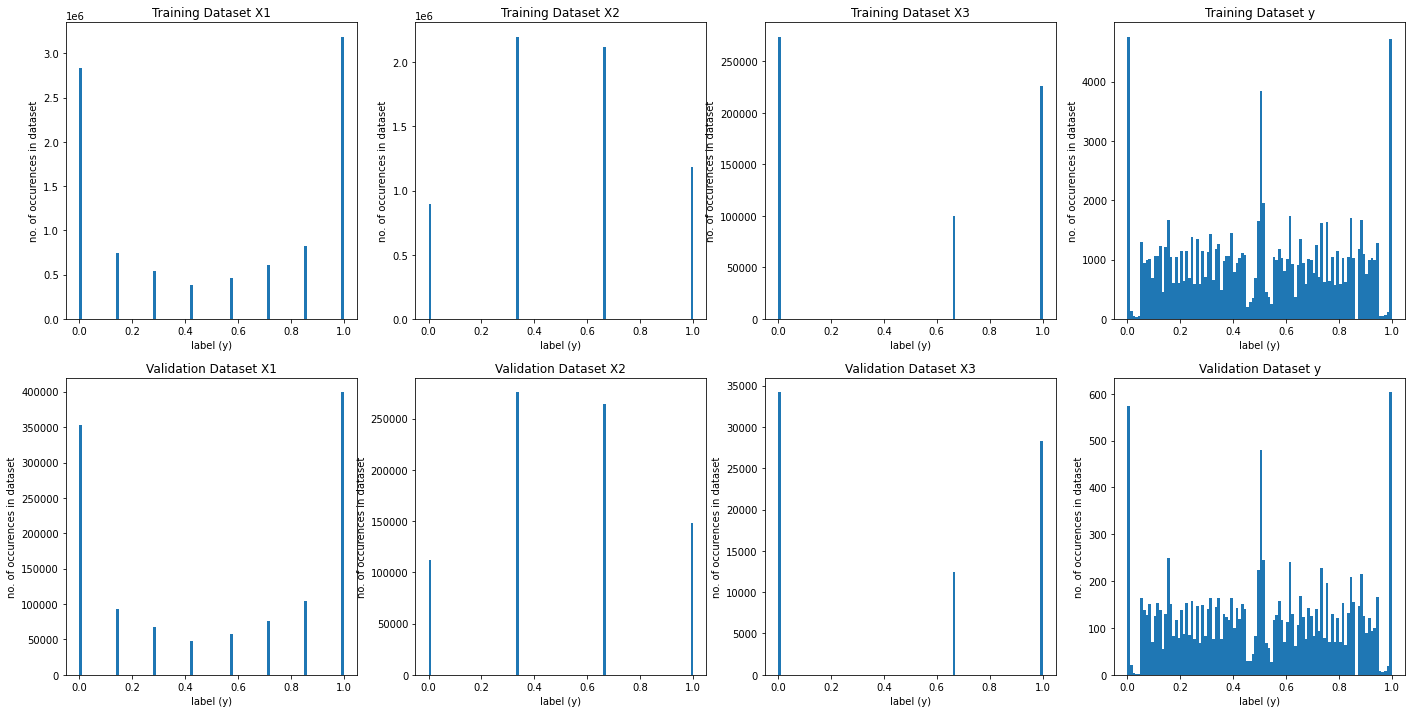

In [27]:
def sanity_check_triple_input(training_data, validation_data):
    _, ax = plt.subplots(nrows=2, ncols=4, figsize=(24, 12))

    ax[0, 0].hist(training_data.X[0].flatten(), bins=100)
    ax[0, 0].set_title(f'Training Dataset X1')
    ax[0, 0].set_xlabel('label (y)')
    ax[0, 0].set_ylabel('no. of occurences in dataset')

    ax[0, 1].hist(training_data.X[1].flatten(), bins=100)
    ax[0, 1].set_title(f'Training Dataset X2')
    ax[0, 1].set_xlabel('label (y)')
    ax[0, 1].set_ylabel('no. of occurences in dataset')

    ax[0, 2].hist(training_data.X[2].flatten(), bins=100)
    ax[0, 2].set_title(f'Training Dataset X3')
    ax[0, 2].set_xlabel('label (y)')
    ax[0, 2].set_ylabel('no. of occurences in dataset')

    ax[0, 3].hist(training_data.y, bins=100)
    ax[0, 3].set_title(f'Training Dataset y')
    ax[0, 3].set_xlabel('label (y)')
    ax[0, 3].set_ylabel('no. of occurences in dataset')

    ax[1, 0].hist(validation_data.X[0].flatten(), bins=100)
    ax[1, 0].set_title(f'Validation Dataset X1')
    ax[1, 0].set_xlabel('label (y)')
    ax[1, 0].set_ylabel('no. of occurences in dataset')

    ax[1, 1].hist(validation_data.X[1].flatten(), bins=100)
    ax[1, 1].set_title(f'Validation Dataset X2')
    ax[1, 1].set_xlabel('label (y)')
    ax[1, 1].set_ylabel('no. of occurences in dataset')

    ax[1, 2].hist(validation_data.X[2].flatten(), bins=100)
    ax[1, 2].set_title(f'Validation Dataset X3')
    ax[1, 2].set_xlabel('label (y)')
    ax[1, 2].set_ylabel('no. of occurences in dataset')

    ax[1, 3].hist(validation_data.y, bins=100)
    ax[1, 3].set_title(f'Validation Dataset y')
    ax[1, 3].set_xlabel('label (y)')
    ax[1, 3].set_ylabel('no. of occurences in dataset')

    plt.show()

sanity_check_triple_input(training_data, validation_data)

#### Reduce the number of samples that are ~50% to further balance the dataset



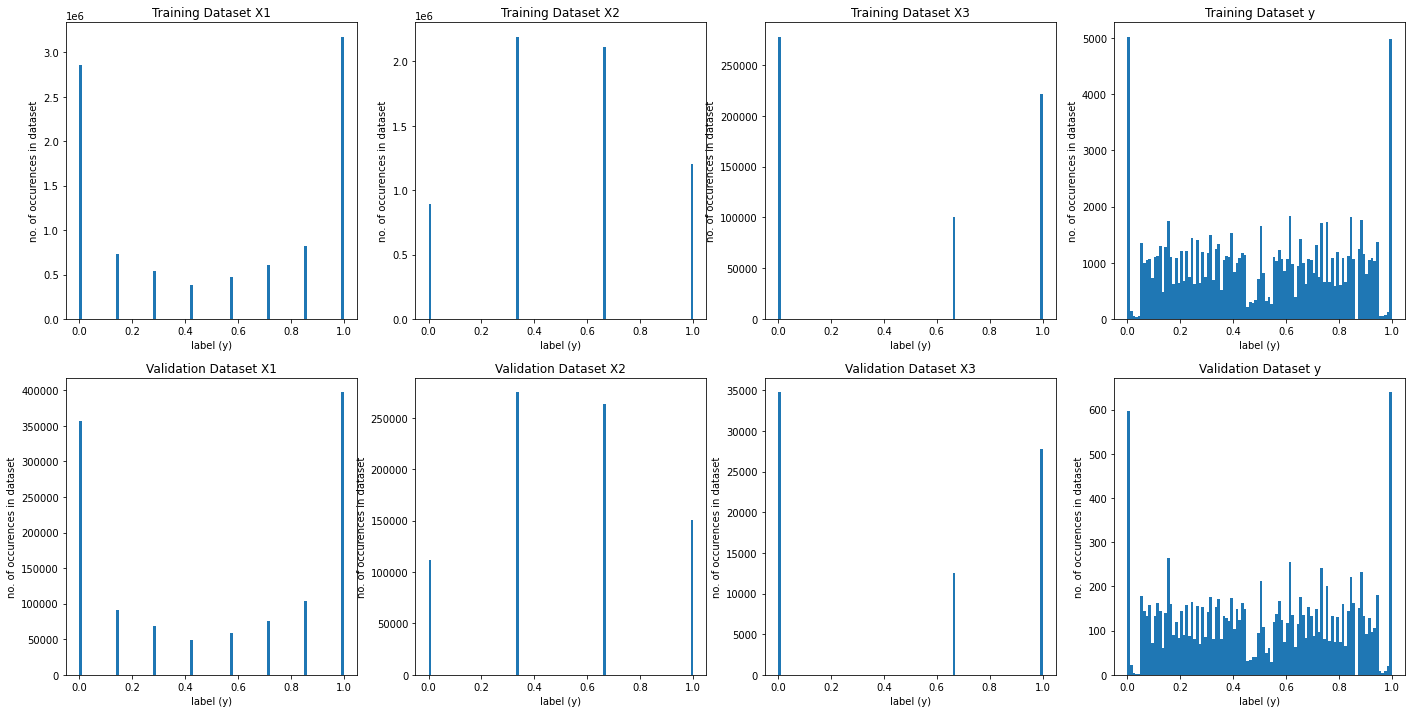

In [29]:
for i in range(training_data.n):
    if 0.475 < training_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * training_data.n))
            training_data.y[i] = training_data.y[index]
            training_data.X[0][i] = training_data.X[0][index]
            training_data.X[1][i] = training_data.X[1][index]
            training_data.X[2][i] = training_data.X[2][index]

for i in range(validation_data.n):
    if 0.475 < validation_data.y[i] < 0.525:
        if np.random.rand() < 0.6:
            index = math.floor((np.random.rand() * validation_data.n))
            validation_data.y[i] = validation_data.y[index]
            validation_data.X[0][i] = validation_data.X[0][index]
            validation_data.X[1][i] = validation_data.X[1][index]
            validation_data.X[2][i] = validation_data.X[2][index]

sanity_check_triple_input(training_data, validation_data)

### The model we will be using

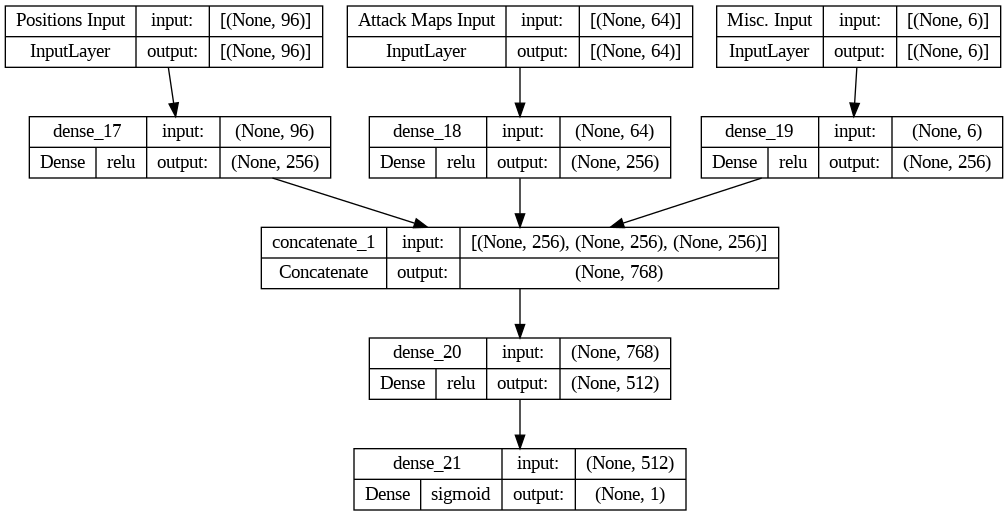

In [30]:
input_shapes = modelinput.ModelInput('all').input_length()

position_input = keras.layers.Input(shape=int(input_shapes[0]), name='Positions Input')
attacks_input = keras.layers.Input(shape=int(input_shapes[1]), name='Attack Maps Input')
misc_inputs = keras.layers.Input(shape=int(input_shapes[2]), name='Misc. Input')

position_dense = keras.layers.Dense(256, activation='relu')(position_input)
attacks_dense = keras.layers.Dense(256, activation='relu')(attacks_input)
misc_dense = keras.layers.Dense(256, activation='relu')(misc_inputs)
x = keras.layers.Concatenate()([position_dense, attacks_dense, misc_dense])
x = keras.layers.Dense(512, activation='relu')(x)
x = keras.layers.Dense(1, activation='sigmoid')(x)

model = keras.models.Model(inputs=[position_input, attacks_input, misc_inputs], outputs=x)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
	metrics=[keras.metrics.MeanAbsoluteError()]
)

keras.utils.plot_model(model, show_shapes=True, show_layer_activations=True, to_file='triple_input_model.png')

## Training either Model

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    restore_best_weights=True,
    patience=5,
    verbose=1)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=1,
    min_lr=0.000000000001,
    verbose=1)

checkpoint = keras.callbacks.ModelCheckpoint(
    f'{working_directory}/model',
    monitor='val_loss',
    save_best_only=True)

tensorboard = keras.callbacks.TensorBoard(
    log_dir=f'{working_directory}/logs',
    write_graph=True,
    write_images=True,
    histogram_freq=1)

model.fit(
    training_data,
    epochs=128,
    validation_data=validation_data,
    callbacks=[early_stopping, reduce_lr, checkpoint, tensorboard])

Epoch 1/128
3125/3125 [==============================] - 18s 5ms/step - loss: 0.0715 - mean_absolute_error: 0.2194 - val_loss: 0.0680 - val_mean_absolute_error: 0.2118 - lr: 0.0010
Epoch 2/128
3114/3125 [============================>.] - ETA: 0s - loss: 0.0650 - mean_absolute_error: 0.2060
Epoch 2: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0650 - mean_absolute_error: 0.2059 - val_loss: 0.0690 - val_mean_absolute_error: 0.2096 - lr: 0.0010
Epoch 3/128
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0576 - mean_absolute_error: 0.1908 - val_loss: 0.0608 - val_mean_absolute_error: 0.1950 - lr: 2.0000e-04
Epoch 4/128
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0548 - mean_absolute_error: 0.1850 - val_loss: 0.0586 - val_mean_absolute_error: 0.1918 - lr: 2.0000e-04
Epoch 5/128
3125/3125 [==============================] - 15s 5ms/step - loss: 0.0523 - mean_a

## Model Evaluation

### Optionally load a previous model

In [ ]:
model = keras.models.load_model(f'{working_directory}/model')

### Histograms and predictions

12500/12500 [==============================] - 27s 2ms/step


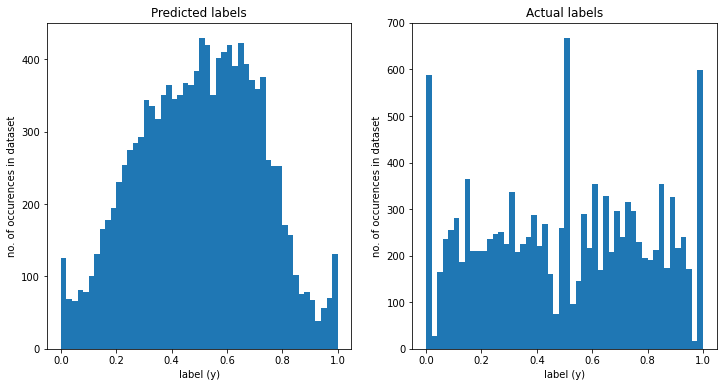

[Text(0.5, 15.0, 'Predicted label'), Text(33.0, 0.5, 'True label')]

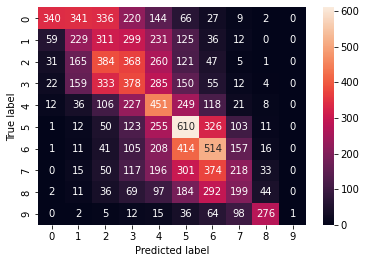

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

testing_data = DataGenerator(data_directory + '/test_set.npz', 'all', batch_size=1)
evaluation = model.evaluate(testing_data)
predictions = model.predict(testing_data)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
ax[0].hist(predictions, bins=50)
ax[0].set_title(f'Predicted labels')
ax[0].set_xlabel('label (y)')
ax[0].set_ylabel('no. of occurences in dataset')
ax[1].hist(testing_data.y, bins=50)
ax[1].set_title(f'Actual labels')
ax[1].set_xlabel('label (y)')
ax[1].set_ylabel('no. of occurences in dataset')
plt.show()

# Bin the data into continuous intervals, then plot a confusion matrix
predictions_binned = np.digitize(predictions, bins=np.linspace(0, 1, 10))
y_binned = np.digitize(testing_data.y, bins=np.linspace(0, 1, 10))
cm = confusion_matrix(y_binned, predictions_binned)
ax = sns.heatmap(cm, annot=True, fmt='d')
ax.set(xlabel='Predicted label', ylabel='True label')

## Why not play a game after all that training?

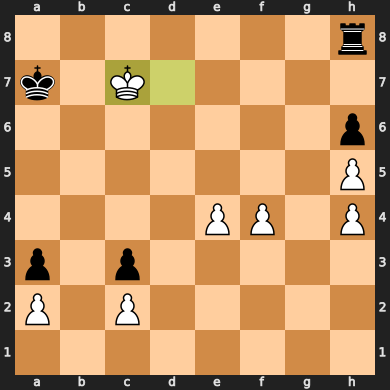

'1/2-1/2'

In [ ]:
import time
from IPython.display import clear_output
import chessbot
import importlib
importlib.reload(chessbot.chessbot)
import chessbot
from chessbot.chessbot import ChessBot

def play_game(model, exploration_rate=0.0, should_visualise=False):
	white = ChessBot(model, chess.WHITE, exploration_rate)
	black = ChessBot(model, chess.BLACK, exploration_rate)
	board = chess.Board()

	if should_visualise:
		display(board)

#chess.Move.from_uci(input())
	while not board.is_game_over(claim_draw=True):
		board.push(black.move(board) if board.turn == chess.BLACK else white.move(board))

		if should_visualise:
			time.sleep(1)
			clear_output(wait=True)
			display(board)

	return board.outcome(claim_draw=True).result()
 
play_game(model, should_visualise=True)